In [224]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow import keras
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, confusion_matrix

In [186]:
df = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")

In [187]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


ID column does not have any relatio with churn.
Let's drop this column.

In [188]:
df.drop(columns=['customerID'], inplace=True)

As we see Total Charges has object datatype
Let's handle it

In [189]:
# There are 11 values which are " " we should drop these
df = df[df['TotalCharges'] != ' ']
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'])

In [190]:
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
numeric_cols = [col for col in numeric_cols if col != 'SeniorCitizen']

object_columns = df.select_dtypes(include=['object']).columns
for col in object_columns:
    print(f'{col}: {df[col].unique()}')

gender: ['Female' 'Male']
Partner: ['Yes' 'No']
Dependents: ['No' 'Yes']
PhoneService: ['No' 'Yes']
MultipleLines: ['No phone service' 'No' 'Yes']
InternetService: ['DSL' 'Fiber optic' 'No']
OnlineSecurity: ['No' 'Yes' 'No internet service']
OnlineBackup: ['Yes' 'No' 'No internet service']
DeviceProtection: ['No' 'Yes' 'No internet service']
TechSupport: ['No' 'Yes' 'No internet service']
StreamingTV: ['No' 'Yes' 'No internet service']
StreamingMovies: ['No' 'Yes' 'No internet service']
Contract: ['Month-to-month' 'One year' 'Two year']
PaperlessBilling: ['Yes' 'No']
PaymentMethod: ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
Churn: ['No' 'Yes']


In [191]:
# Define mappings for columns with 'Yes'/'No'/'No service' values
yes_no_map = {'Yes': 1, 'No': 0, 'No internet service': 0, 'No phone service': 0}

# Columns with 'Yes'/'No'/'No service' values
yes_no_columns = ['Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'Churn', 
                  'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 
                  'StreamingTV', 'StreamingMovies', 'MultipleLines']

# Encode the relevant columns
for col in yes_no_columns:
    df[col] = df[col].map(yes_no_map)

# Encode 'Male' as 1 and 'Female' as 0 for the 'gender' column   
df['gender'] = df['gender'].map({'Male': 1, 'Female': 0})

# One-hot encode categorical columns with multiple categories
df = pd.get_dummies(df, columns=['InternetService', 'Contract', 'PaymentMethod'], drop_first=True)
df = df.astype(int)

In [192]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0 to 7042
Data columns (total 24 columns):
 #   Column                                 Non-Null Count  Dtype
---  ------                                 --------------  -----
 0   gender                                 7032 non-null   int32
 1   SeniorCitizen                          7032 non-null   int32
 2   Partner                                7032 non-null   int32
 3   Dependents                             7032 non-null   int32
 4   tenure                                 7032 non-null   int32
 5   PhoneService                           7032 non-null   int32
 6   MultipleLines                          7032 non-null   int32
 7   OnlineSecurity                         7032 non-null   int32
 8   OnlineBackup                           7032 non-null   int32
 9   DeviceProtection                       7032 non-null   int32
 10  TechSupport                            7032 non-null   int32
 11  StreamingTV                        

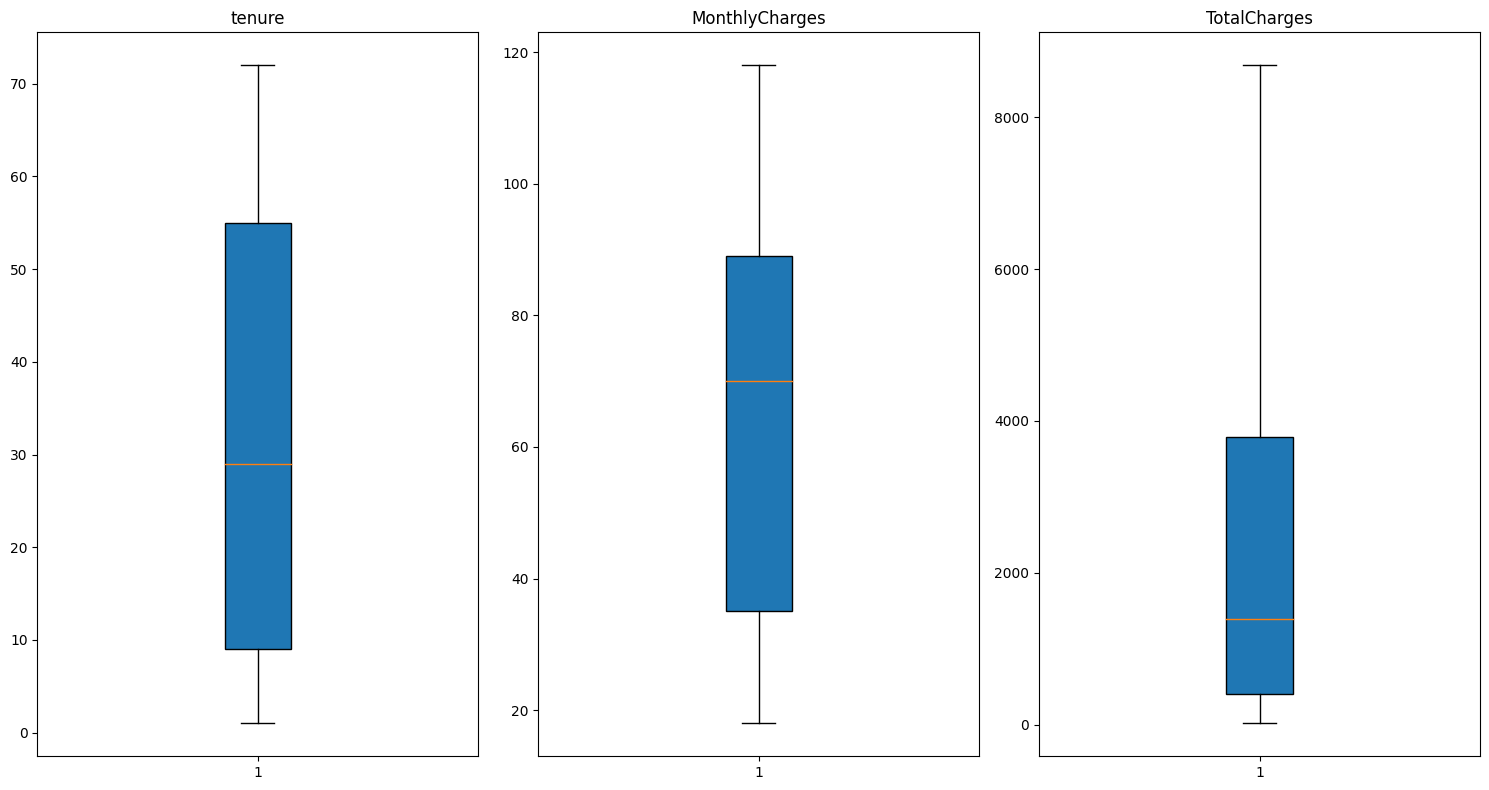

In [193]:
# Create boxplots for numeric columns
plt.figure(figsize=(15, 8))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(1, len(numeric_cols), i)
    plt.boxplot(df[col], vert=True, patch_artist=True)
    plt.title(col)
    plt.tight_layout()

plt.show()

There is no outliers in numeric cols

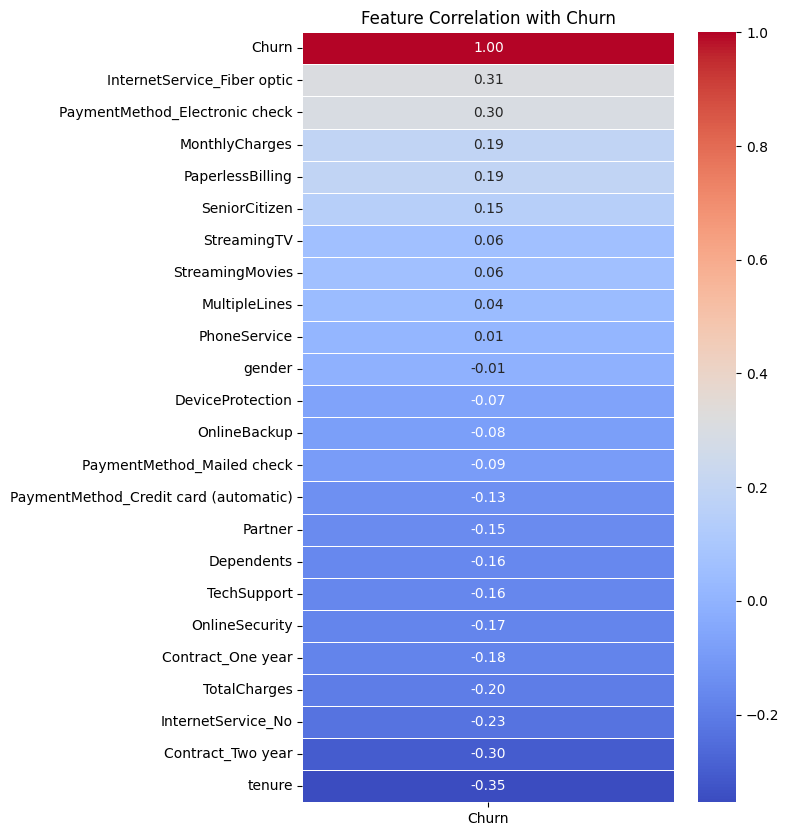

In [194]:
# Compute correlations of all features with the target variable 'Churn'
churn_correlation = df.corr()[['Churn']].sort_values(by='Churn', ascending=False)

# Plot a heatmap for the correlation of features with 'Churn'
plt.figure(figsize=(6, 10))  # Adjust figure size for better visibility
sns.heatmap(churn_correlation, annot=True, cmap='coolwarm', fmt=".2f", cbar=True, linewidths=0.5)
plt.title('Feature Correlation with Churn')
plt.show()

In [195]:
skewness = df[numeric_cols].skew()
print(skewness)

tenure            0.237731
MonthlyCharges   -0.221742
TotalCharges      0.961636
dtype: float64


In [196]:
# Check skewness and take action if skewness > 0.5 or < -0.5
for col in numeric_cols:
    col_skew = skewness[col]  # Access skewness of the current column
    if col_skew > 0.5:
        # Log transformation for positive skewness
        df[col] = np.log1p(df[col])  # log1p handles zero or negative values safely
        print(f"Transformed {col} with log transformation due to positive skewness.")
    elif col_skew < -0.5:
        # Exp transformation for negative skewness
        # Ensure no negative values before applying exp transformation
        df[col] = np.exp(df[col] - 1)  # Apply exp transformation and shift by 1 to avoid very small values
        print(f"Transformed {col} with exp transformation due to negative skewness.")

Transformed TotalCharges with log transformation due to positive skewness.


In [197]:
df[numeric_cols].describe()

,tenure,MonthlyCharges,TotalCharges
count,7032.000000,7032.000000,7032.000000
mean,32.421786,64.332480,6.941574
std,24.545260,30.088668,1.549533
min,1.000000,18.000000,2.944439
25%,9.000000,35.000000,5.996452
50%,29.000000,70.000000,7.242798
75%,55.000000,89.000000,8.241506
max,72.000000,118.000000,9.069353


In [198]:
df[numeric_cols] = MinMaxScaler().fit_transform(df[numeric_cols])

In [199]:
X = df.drop(columns=['Churn'])
y = df['Churn']

In [200]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [201]:
print(y_train.value_counts())

Churn
0    4130
1    1495
Name: count, dtype: int64


Now use SMOTE to oversample the minority class in the training set:

In [202]:
# Apply SMOTE on the training data
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

In [203]:
X_train_balanced.shape

(8260, 23)

In [212]:
model = keras.models.Sequential([
    keras.layers.Dense(23, activation='relu', input_shape=(23,)),
    keras.layers.Dense(15, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

model.compile(
    optimizer='adam',                           # Optimizer
    loss='binary_crossentropy',                 # Loss function for binary classification
    metrics=['accuracy']                        # Metric to monitor
)

model.fit(X_train_balanced, y_train_balanced, epochs=20)

Epoch 1/20


d:\python 3.11\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


259/259 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6156 - loss: 0.6239
Epoch 2/20
259/259 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7910 - loss: 0.4572
Epoch 3/20
259/259 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7916 - loss: 0.4543
Epoch 4/20
259/259 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7906 - loss: 0.4500
Epoch 5/20
259/259 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8071 - loss: 0.4334
Epoch 6/20
259/259 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8006 - loss: 0.4338
Epoch 7/20
259/259 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8051 - loss: 0.4219
Epoch 8/20
259/259 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7997 - loss: 0.4309
Epoch 9/20
259/259 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8003 - loss: 0.4239
Epoch 10/20
259/259 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8022 - loss: 0.4235
Epoch 11/20
259/259 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8078 - loss: 0.4167
Epoch 12/20
259/259 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy

In [213]:
model.evaluate(X_test,y_test)

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7586 - loss: 0.4684


[0.483198881149292, 0.7569296360015869]

In [220]:
y_pred = model.predict(X_test)
yp = (y_pred > 0.5).astype(int)

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [223]:
report = classification_report(yp,y_test)
print(report)

              precision    recall  f1-score   support

           0       0.77      0.88      0.82       907
           1       0.71      0.53      0.61       500

    accuracy                           0.76      1407
   macro avg       0.74      0.71      0.72      1407
weighted avg       0.75      0.76      0.75      1407



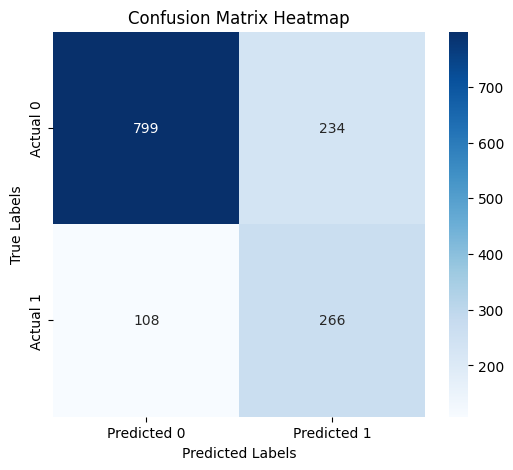

In [225]:
# Generate confusion matrix
cm = confusion_matrix(y_test, yp)

# Create a heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()